In [1]:
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
import torch
import time
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel
from scipy.linalg import svd
import scienceplots
from sklearn.metrics.pairwise import linear_kernel

# X 和 Y 的维度可以不一样
sys.path.insert(0,os.path.abspath('/notebooks/4901_revisit_cdtran'))
sys.path.insert(0,os.path.abspath('/notebooks/pytorchtimseries'))
from tqdm.notebook import tqdm


def xy_plot(x, y, pred_y, title=None, y_label=None):
    with plt.style.context(['science', 'notebook']):

        fig, ax = plt.subplots()
        
        x_ticks = np.arange(len(x))
        y_ticks = np.arange(len(x), len(x)+len(y))
        
        # 设置边框粗度
        for spine in ax.spines.values():
            spine.set_linewidth(2)  # 设置边框粗度为2

        
        ax.plot(x_ticks, x, label='lookback', linewidth=3)
        ax.plot(y_ticks, y, label='ground_truth', linewidth=3)
        ax.plot(y_ticks, pred_y, label='prediction', linewidth=3)
    if y_label: plt.ylabel(y_label)
    if title: plt.title(title)
    plt.legend()
    
# X 和 Y 的维度可以不一样
# K = linear_kernel(X, X)  # K: n x n
# L = linear_kernel(Y, Y)  # L: n x n

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def compute_cka(X, Y):
    K = linear_kernel(X, X)
    L = linear_kernel(Y, Y)
    
    K_c = center_kernel(K)
    L_c = center_kernel(L)
    
    hsic = np.trace(K_c @ L_c)
    norm_k = np.trace(K_c @ K_c)
    norm_l = np.trace(L_c @ L_c)
    
    return hsic / np.sqrt(norm_k * norm_l)

def standardize(X):
    mean_vals = X.mean(axis=1, keepdims=True)
    std_vals = X.std(axis=1, keepdims=True)
    return (X - mean_vals) / (std_vals + 1e-8)  # 避免除以零


plt.style.use(['ieee', 'notebook'])

In [2]:
dataset = "ExchangeRate"
from torch_timeseries.experiments import DLinearForecast, PatchTSTForecast
from src.experiments.CiDPG import CiDPGForecast

exp = CiDPGForecast(dataset_type=dataset, windows=336, horizon=1, pred_len=720, data_path='/notebooks/pytorchtimseries/data', save_dir='/notebooks/4901_revisit_cdtran/results', device='cuda:0')
exp._setup_run(1)
exp._resume_run(1)

# i = 1000
i = 0
batch_x, batch_y, origin_x, origin_y, batch_x_date_enc, batch_y_date_enc = map(lambda x: torch.tensor(x).to(exp.device).unsqueeze(0).float(),  exp.dataloader.test_loader.dataset[i])
pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)


b = 0
v = 5

plot_x = batch_x[b, :, v].cpu().detach().numpy()
plot_y = batch_y[b, :, v].cpu().detach().numpy()
plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()


x_ticks = np.arange(len(plot_x))
y_ticks = np.arange(len(plot_x), len(plot_x)+len(plot_y))

Using downloaded and verified file: /notebooks/pytorchtimseries/data/ExchangeRate/exchange_rate.csv
train steps: 4256
val steps: 798
test steps: 41


/root/anaconda3/envs/testpyt/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/notebooks/pytorchtimseries/torch_timeseries/experiments/forecast.py:378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless the

tensor([128, 182, 238, 292, 348, 402, 458, 512], dtype=torch.int32)
self.t_index [95, 143, 191, 239, 287, 335, 383]
resuming from /notebooks/4901_revisit_cdtran/results/runs/CiDPG/ExchangeRate/w336h1s720/b5d8417215bf20d2f9e7ac6b5f0691fd/run_checkpoint.pth


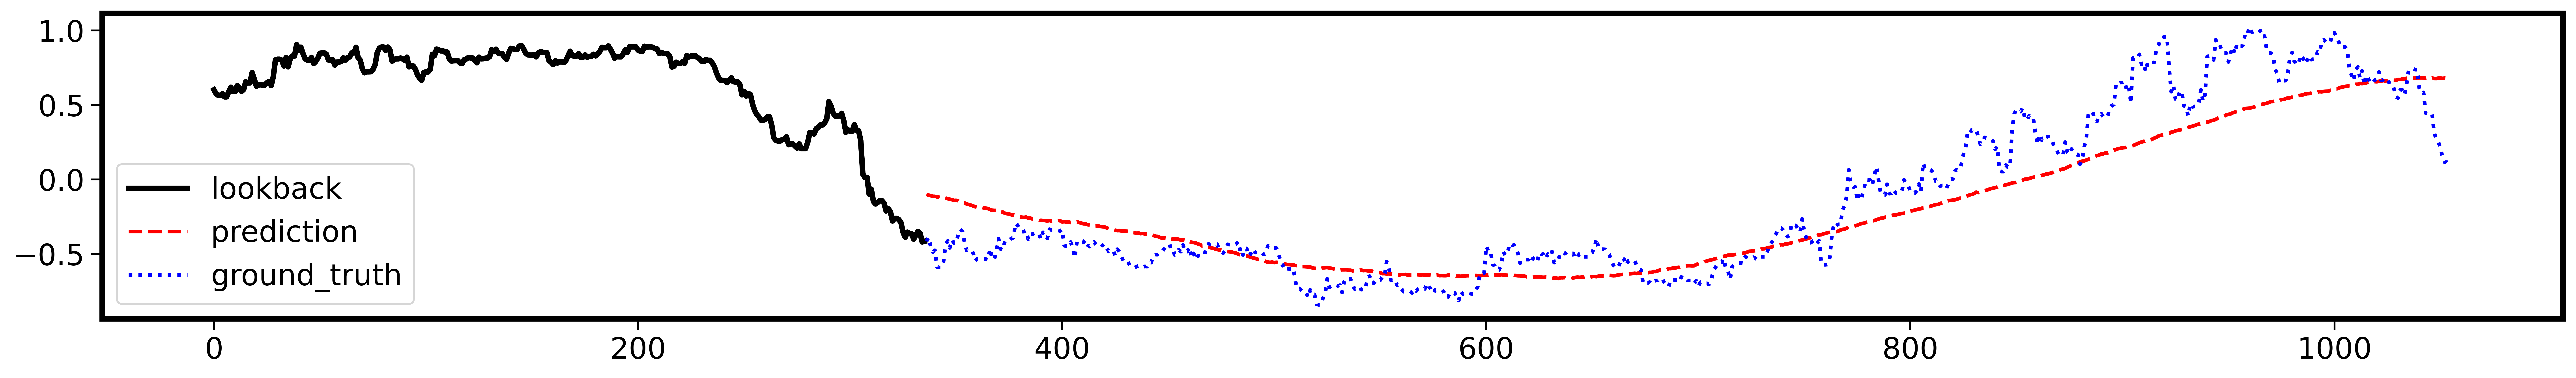

In [8]:

plt.figure(figsize=(24,3))
plt.plot(x_ticks, plot_x, label='lookback', linewidth=3)
# 设置图表边框的粗细
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.plot(y_ticks, plot_y, label='ground_truth')
plt.legend()
# plot_pred_y = pred_y[b, :, :].cpu().detach().numpy()
# plt.plot(x_ticks, batch_x[0].cpu().detach().numpy(), label='lookback')
# plt.plot(y_ticks, batch_y[0].cpu().detach().numpy(), label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
# pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)
# plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()
# xy_plot(plot_x, plot_y, plot_pred_y, 'PEMS07', 'PAN')
plt.savefig('./a.svg')

plt.show()
# plt.savefig('./a.svg')


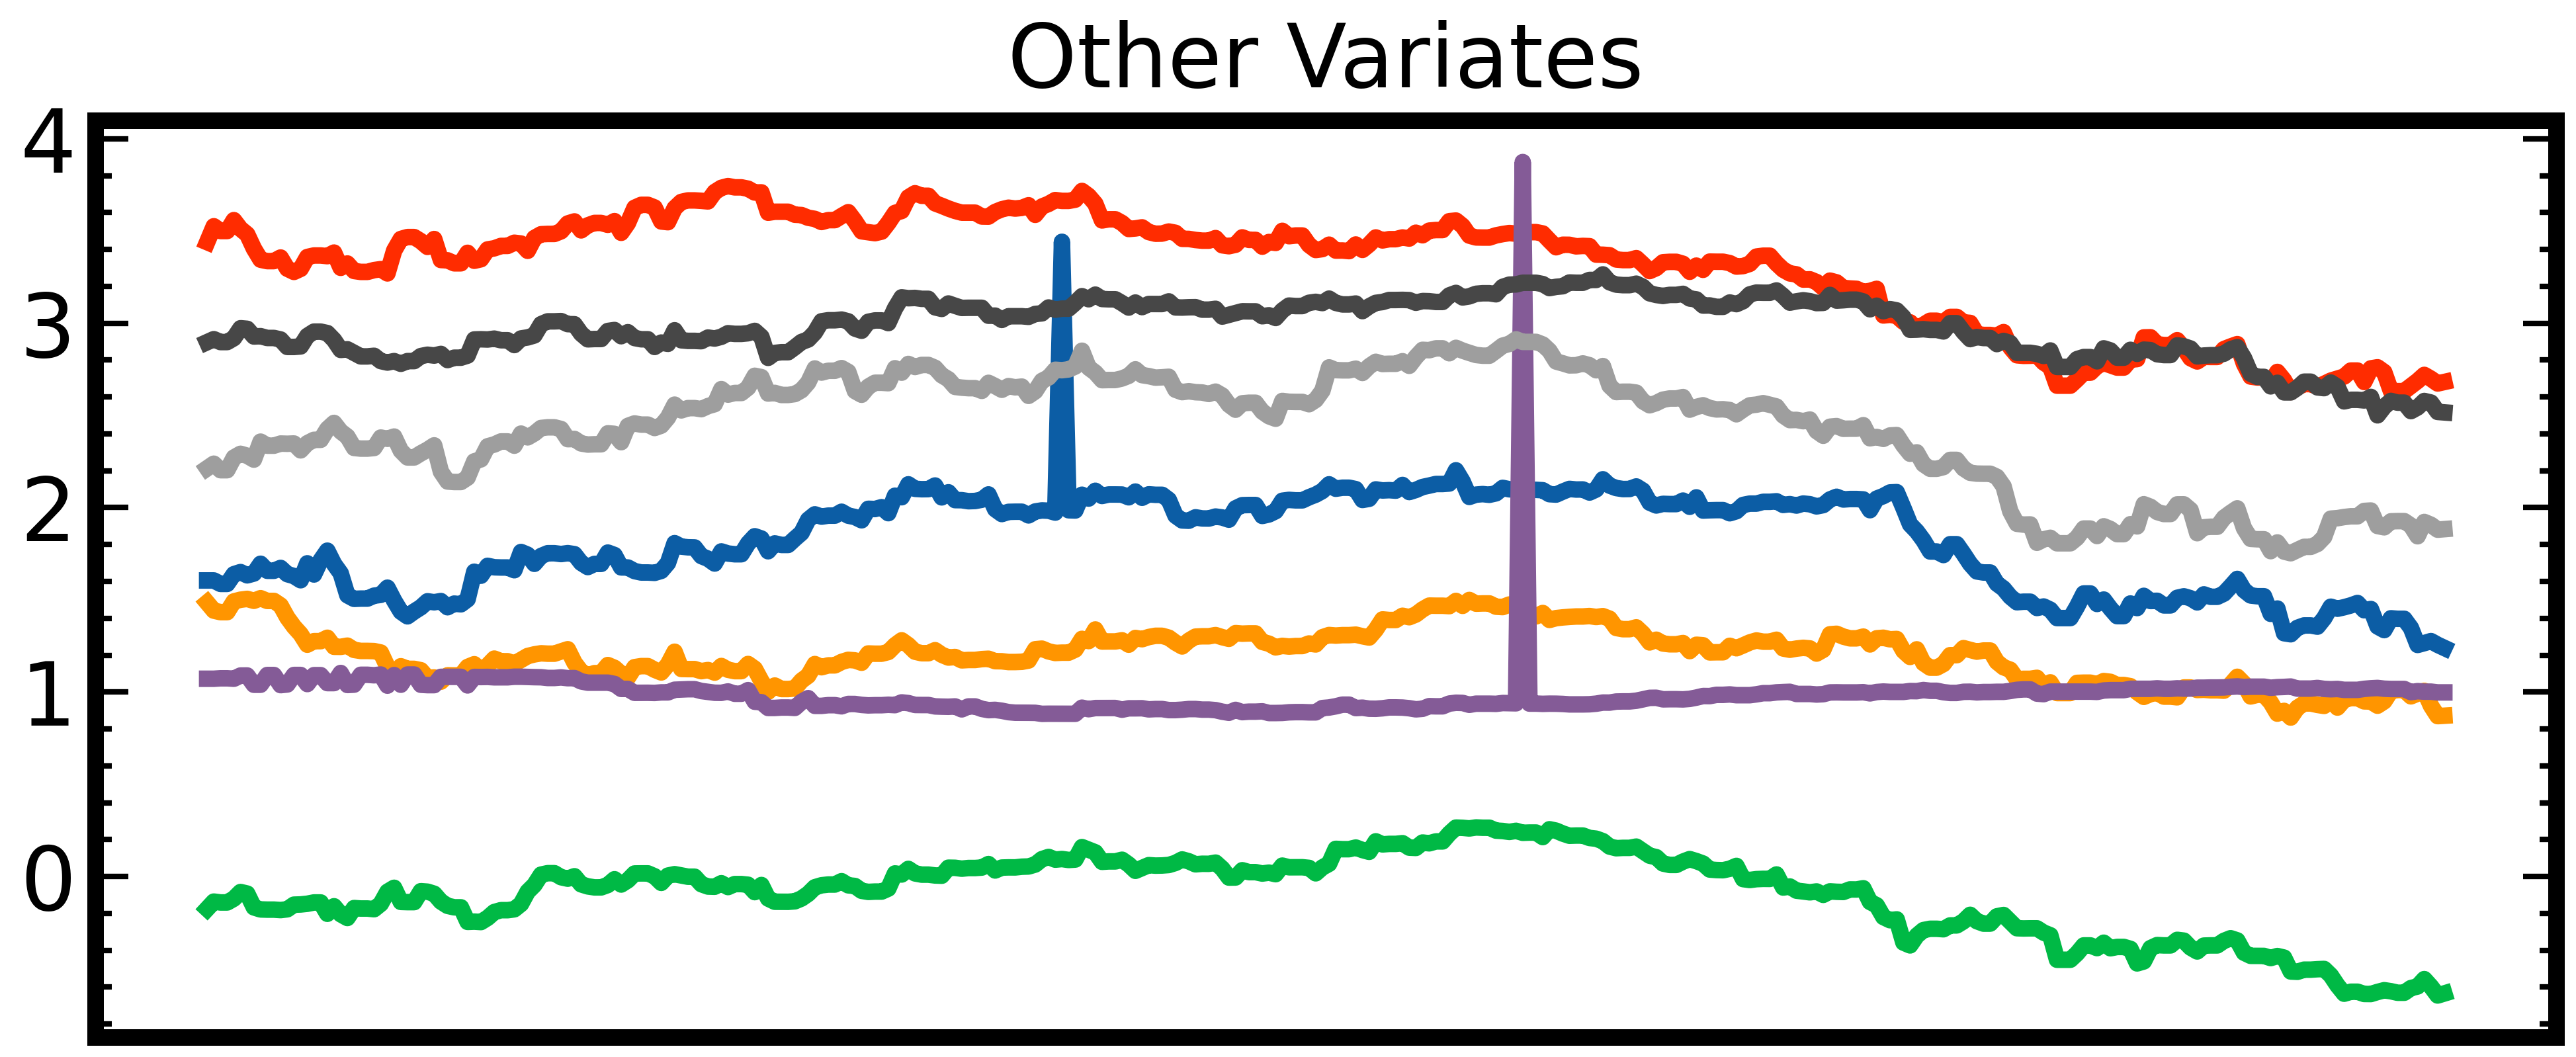

In [30]:


plt.figure(figsize=(8,3))
plt.style.use(['science', 'notebook'])
for i, vi in enumerate([0,1,2,3,4,6,7]):
    plot_x = batch_x[b, :, vi].cpu().detach().numpy()
    plt.plot(x_ticks, plot_x, label=f'v{i+1}', linewidth=3, )
plt.xticks([])
# plt.legend()
# 设置图表边框的粗细
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

plt.title('Other Variates')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
# plt.plot(y_ticks, plot_y, label='ground_truth')
# plt.legend()
# plot_pred_y = pred_y[b, :, :].cpu().detach().numpy()
# plt.plot(x_ticks, batch_x[0].cpu().detach().numpy(), label='lookback')
# plt.plot(y_ticks, batch_y[0].cpu().detach().numpy(), label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
# pred_y, true_y  = exp._process_one_batch(batch_x, batch_y, batch_x_date_enc, batch_y_date_enc)
# plot_pred_y = pred_y[b, :, v].cpu().detach().numpy()
# xy_plot(plot_x, plot_y, plot_pred_y, 'PEMS07', 'PAN')
plt.savefig('./a.svg')


In [3]:


batch_x.shape

torch.nn.functional.pad(batch_x[0], (48, 0))

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.6015,  2.8971,  2.2134],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5761,  2.9135,  2.2383],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5643,  2.8977,  2.2029],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.3620,  2.5697,  1.9070],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.4201,  2.5190,  1.8805],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.4165,  2.5163,  1.8834]],
       device='cuda:0')

In [5]:
aa = torch.nn.functional.pad(batch_x[0].transpose(0,1), (48, 0))
caps = aa[:, [95, 143, 191, 239, 287, 335, 383]].cpu().detach().numpy()

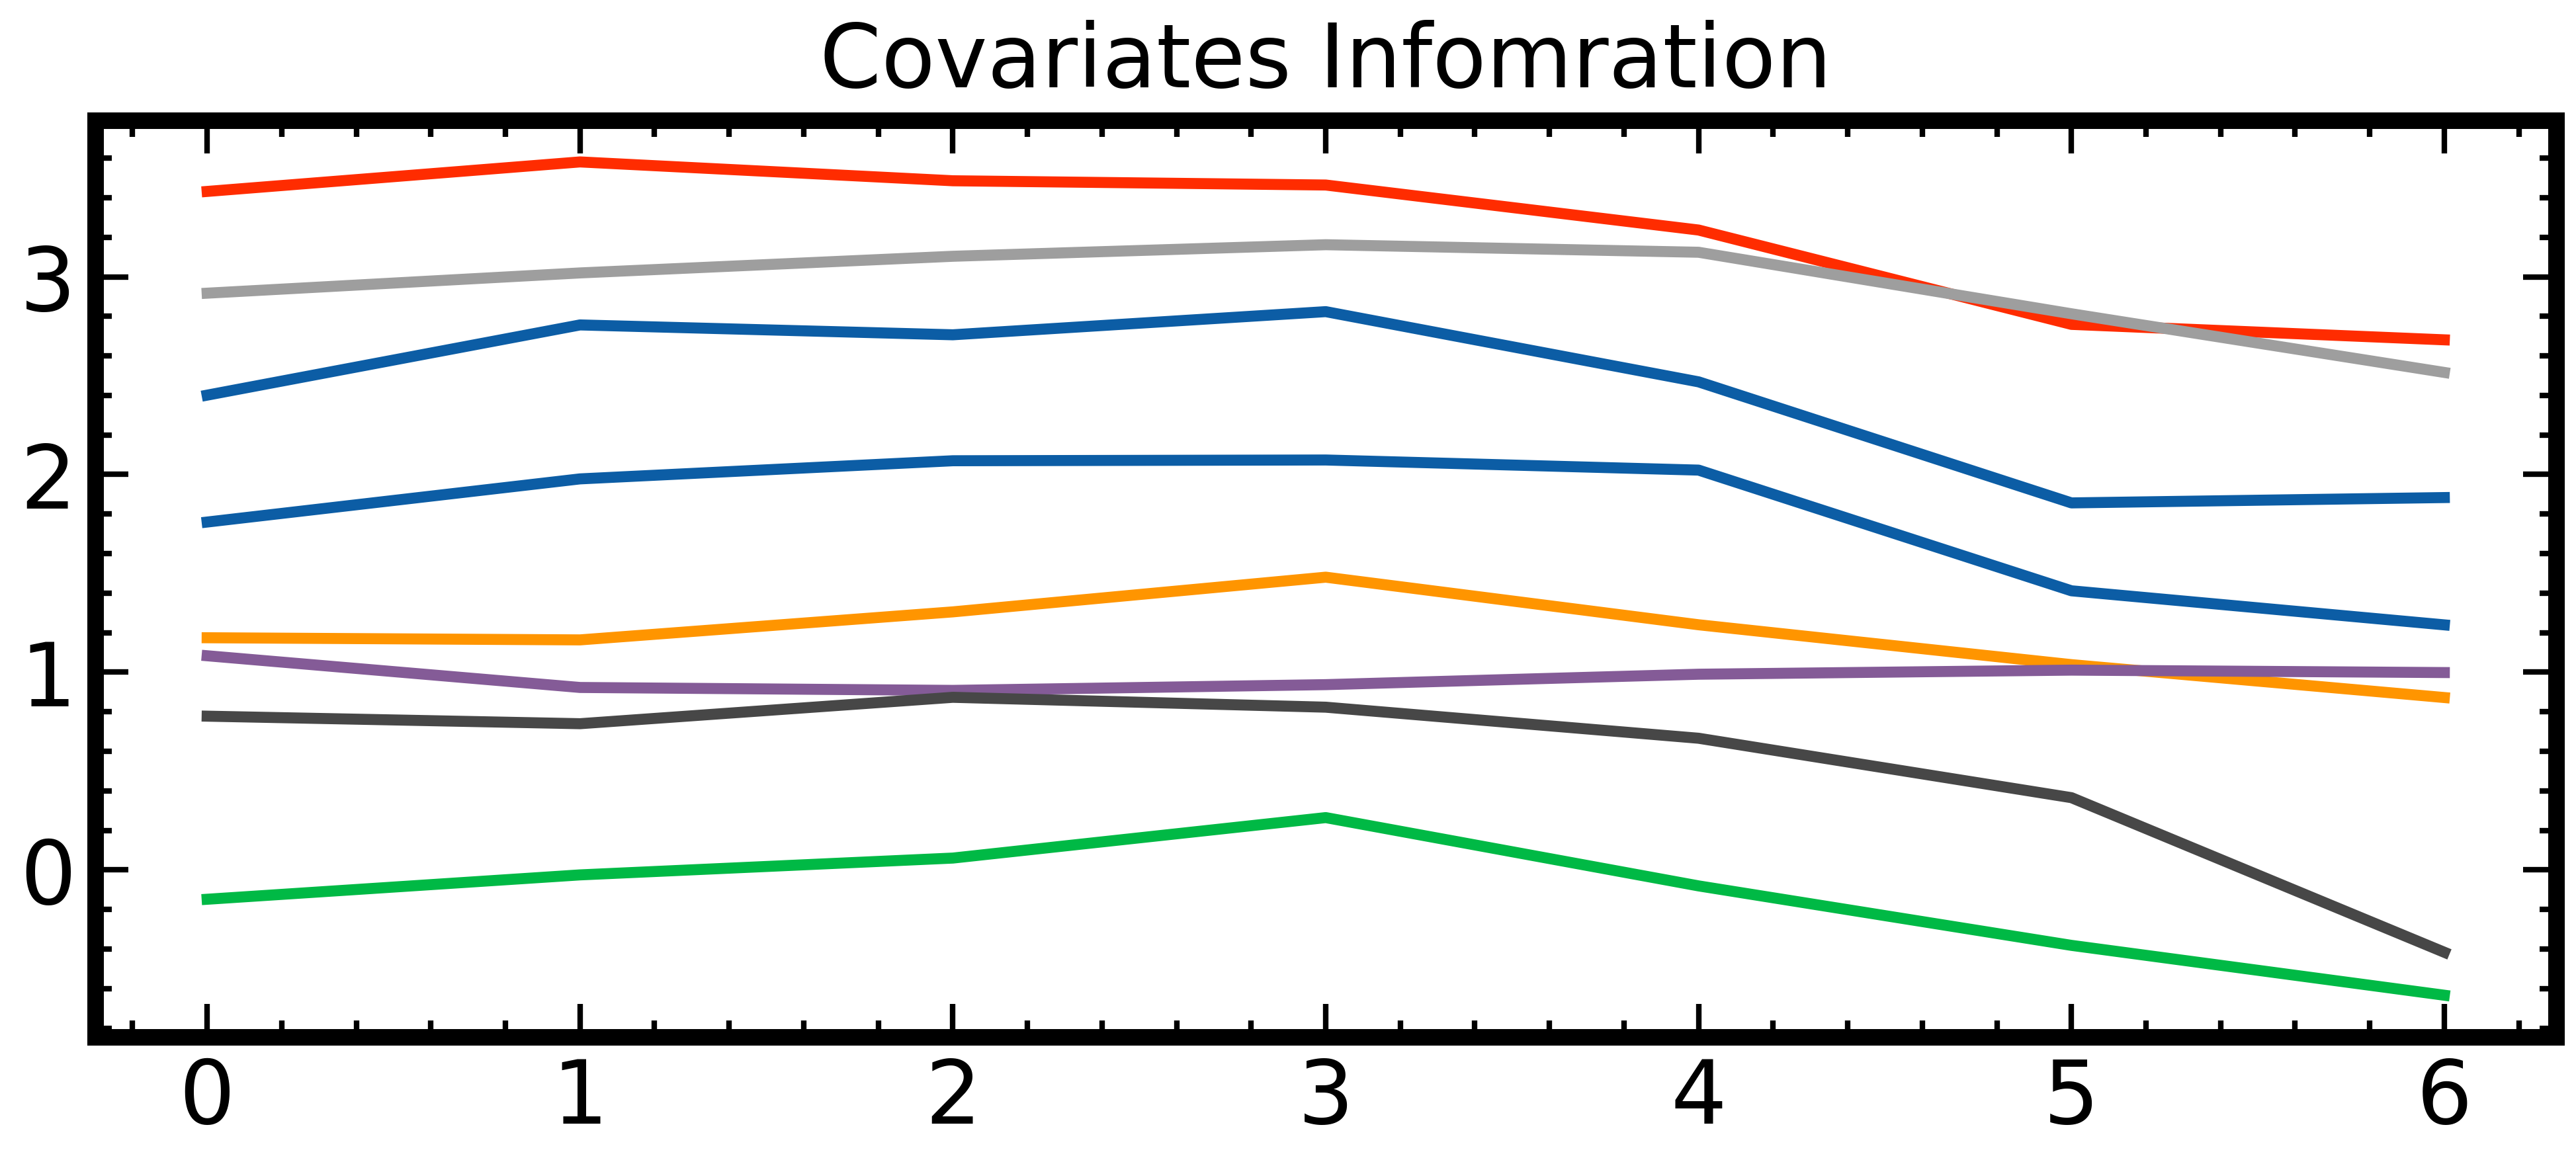

In [56]:
plt.figure(figsize=(8, 3))
plt.style.use(['science', 'notebook'])
plt.title('Covariates Infomration')
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)
for i in range(8):
    plt.plot(caps[i, :], label=f'CAP{i+1}')
# plt.legend()
# plt.savefig("bb.svg")


In [62]:
caps.shape

(8, 7)

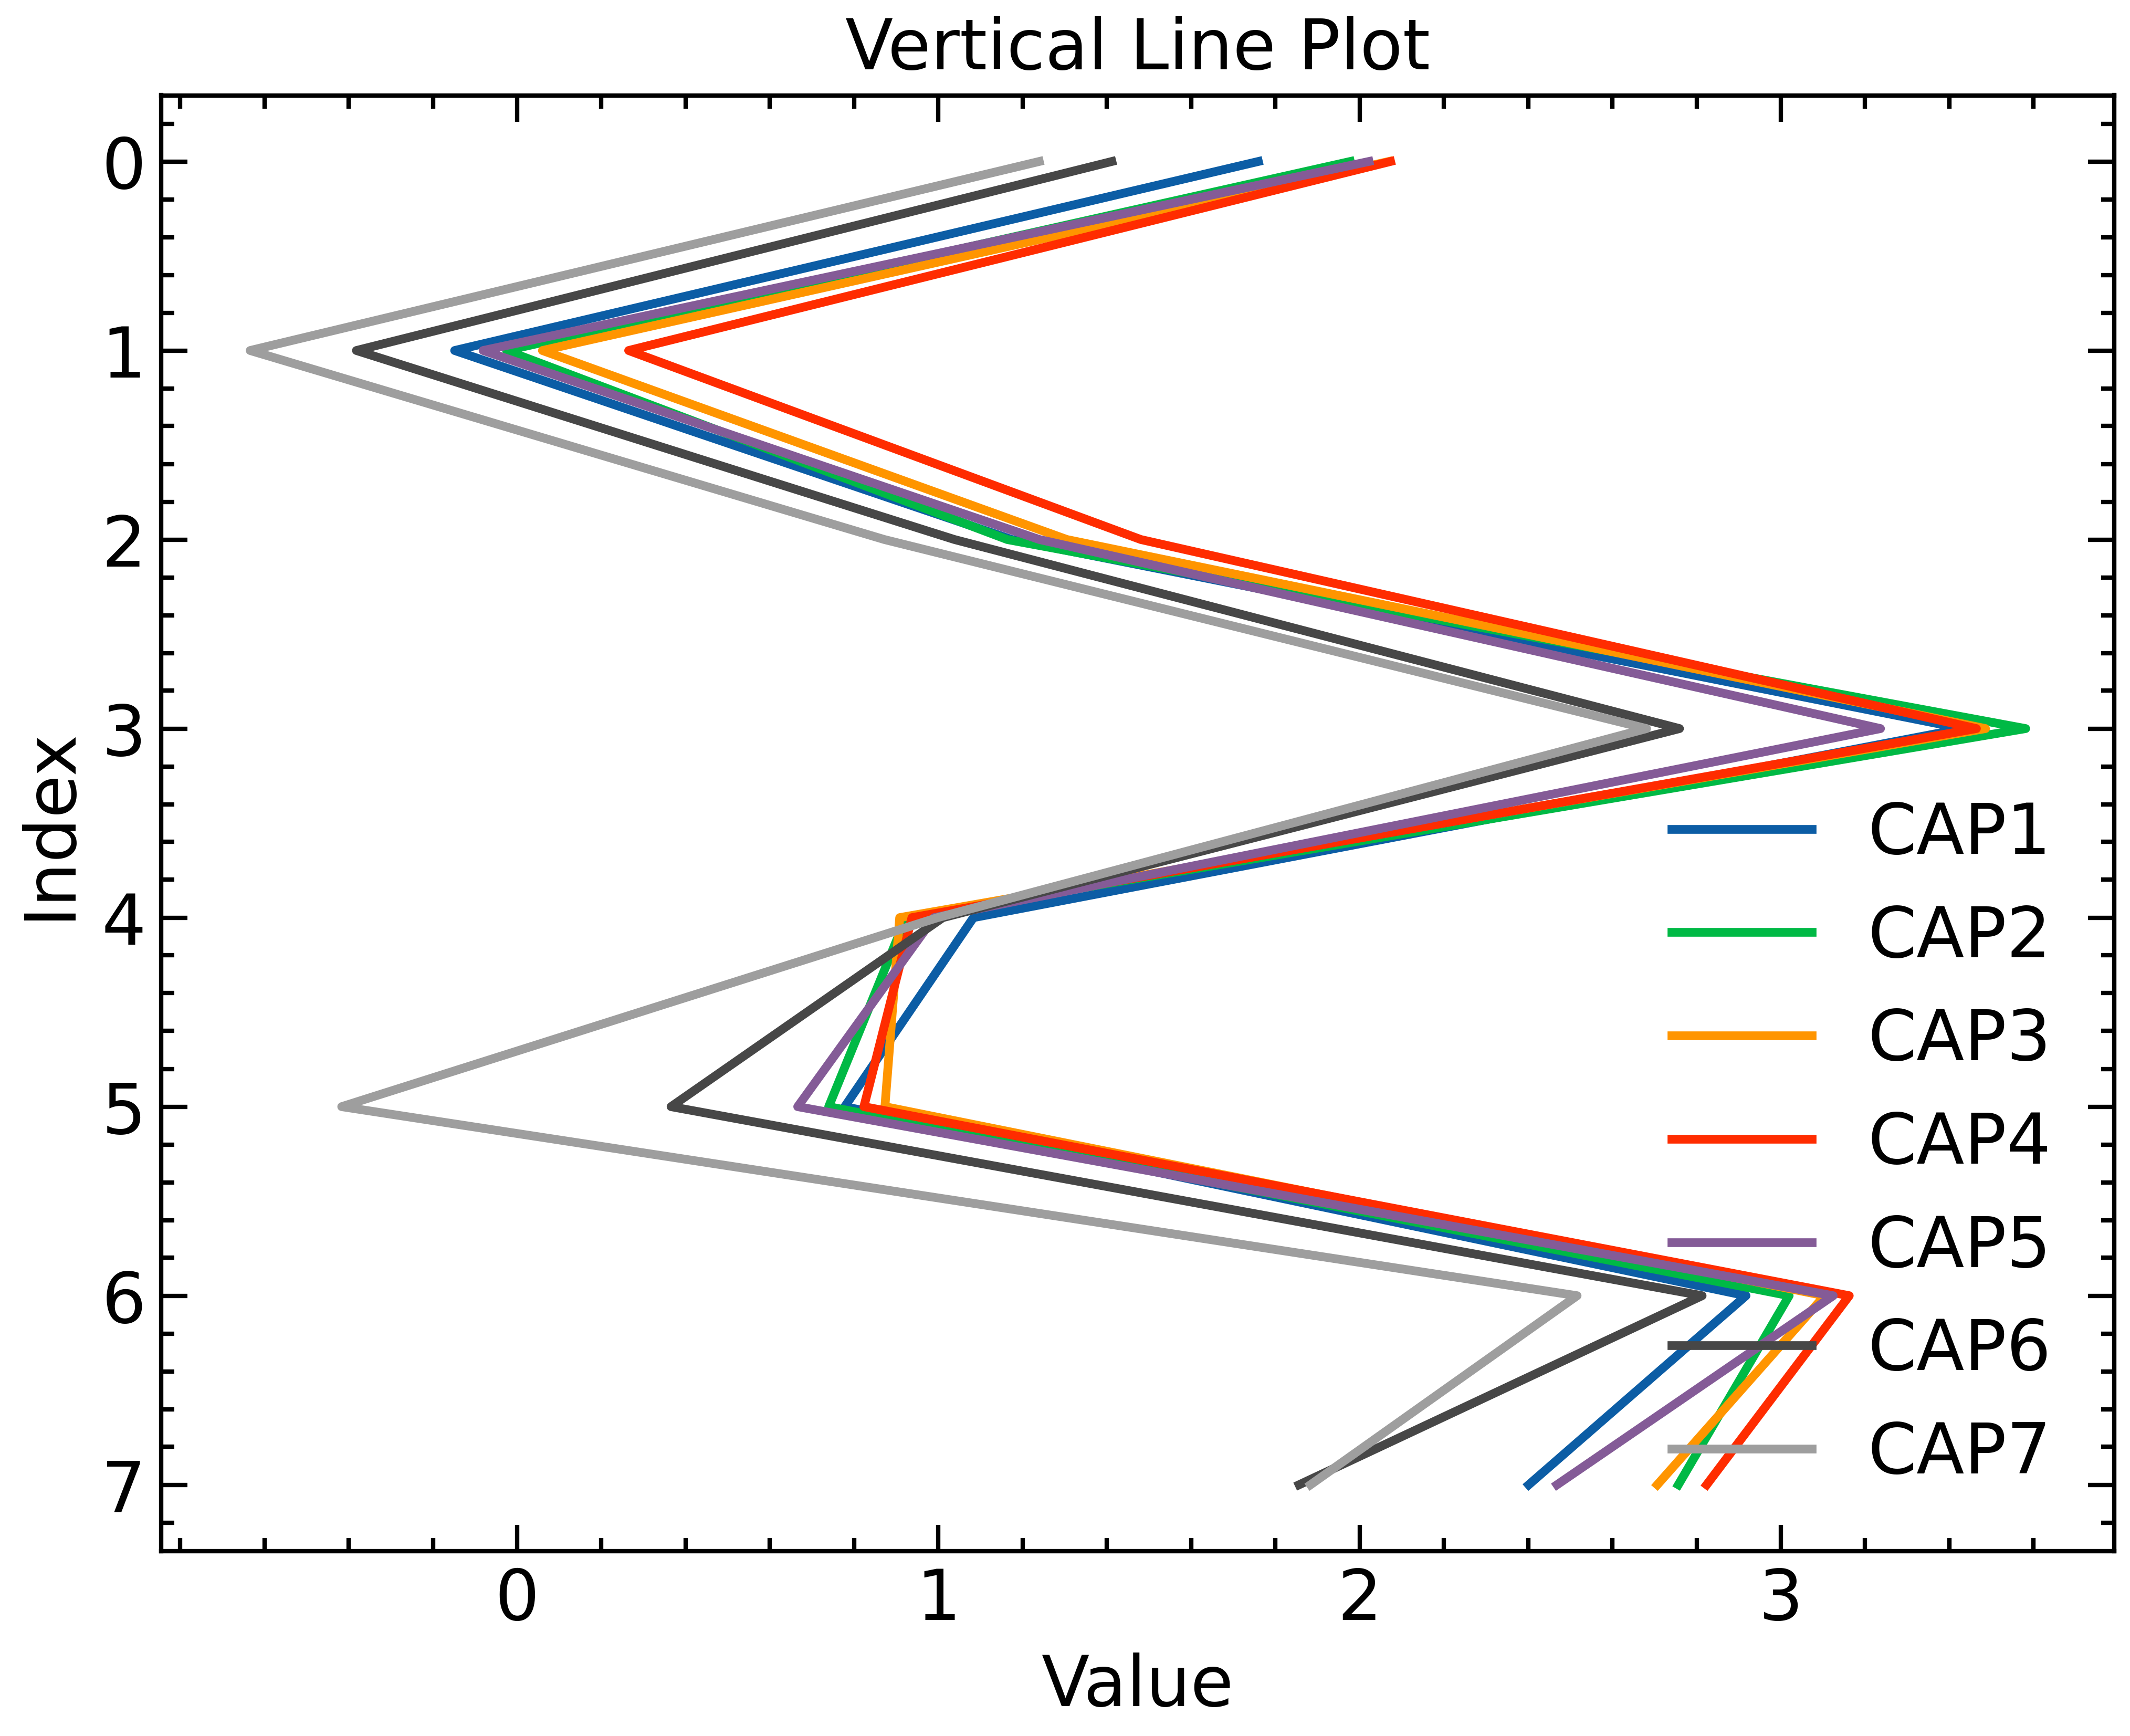

In [63]:
import matplotlib.pyplot as plt

# 示例数据（假设 caps 是一个二维数组或 DataFrame）
# caps = np.random.rand(8, 10)  # 8 行（CAP1 到 CAP8），10 列（横坐标）

plt.figure(figsize=(8, 6))  # 设置图像尺寸

for i in range(7):
    plt.plot(caps[:, i], range(len(caps[:, i])), label=f'CAP{i+1}')  # 调换 x 和 y

plt.xlabel('Value')  # x 轴代表值
plt.ylabel('Index')  # y 轴代表数据索引
plt.title('Vertical Line Plot')  # 图标题
plt.legend(loc='lower right')  # 显示图例，放置在右下角
# plt.grid(True)  # 显示网格
plt.gca().invert_yaxis()  # 可选：如果需要从上到下显示索引
plt.show()


In [12]:
patches = aa.unfold(dimension=-1, size=96, step=48)
patches[v].shape

torch.Size([7, 96])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


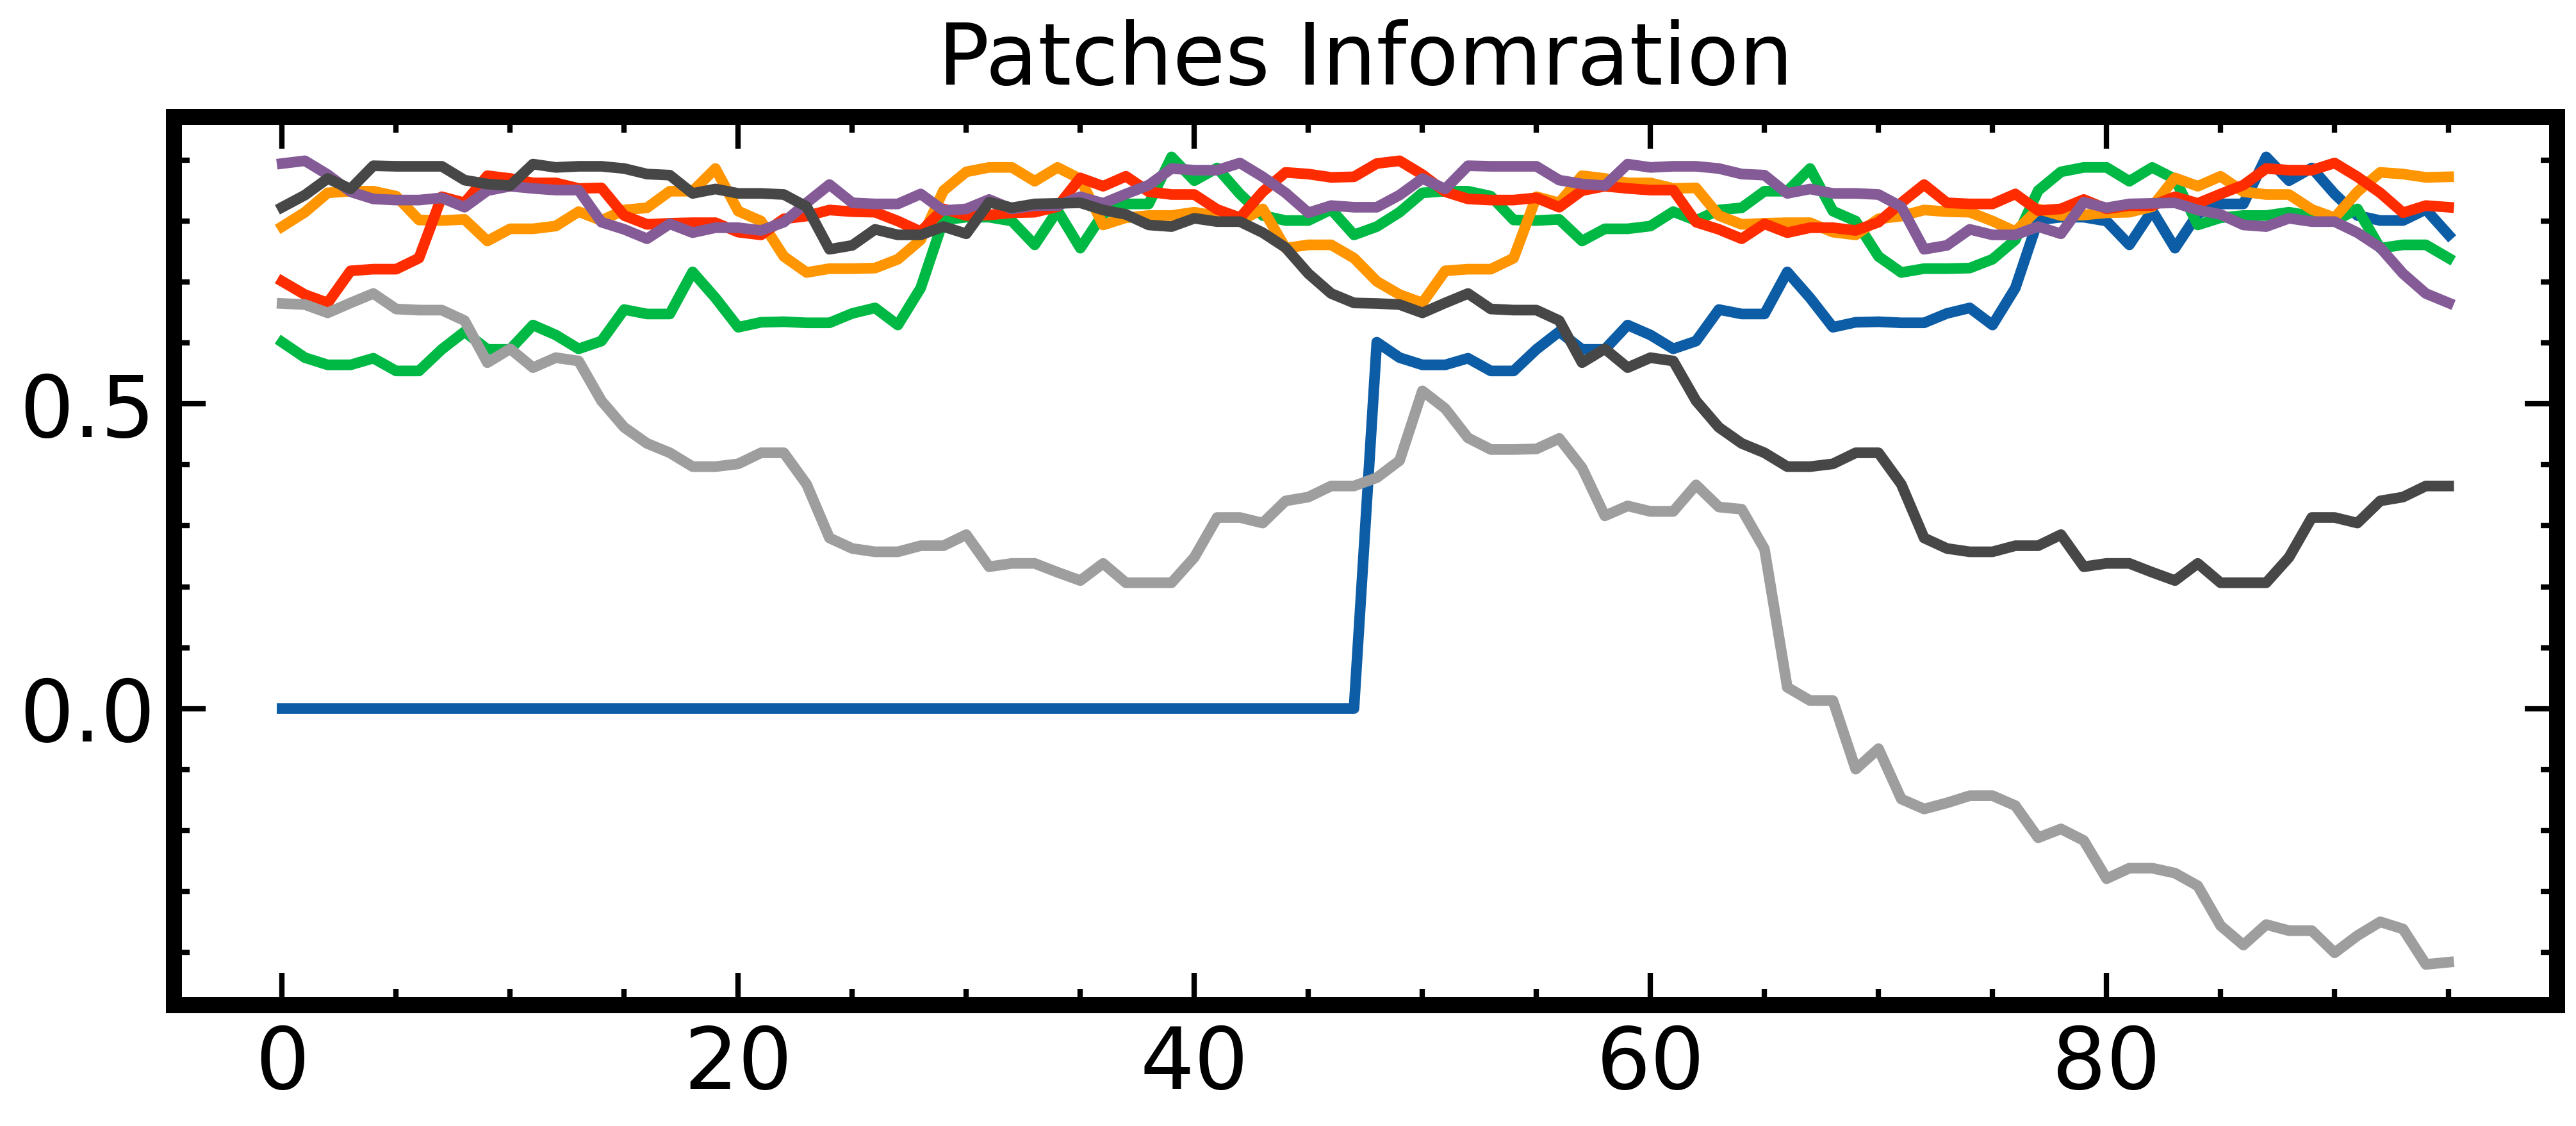

In [23]:

plt.figure(figsize=(8, 3))
plt.style.use(['science', 'notebook'])
plt.title('Patches Infomration')
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)
# plt.plot(caps)
plt.plot(patches[v].transpose(1,0).cpu().detach().numpy())
plt.legend()


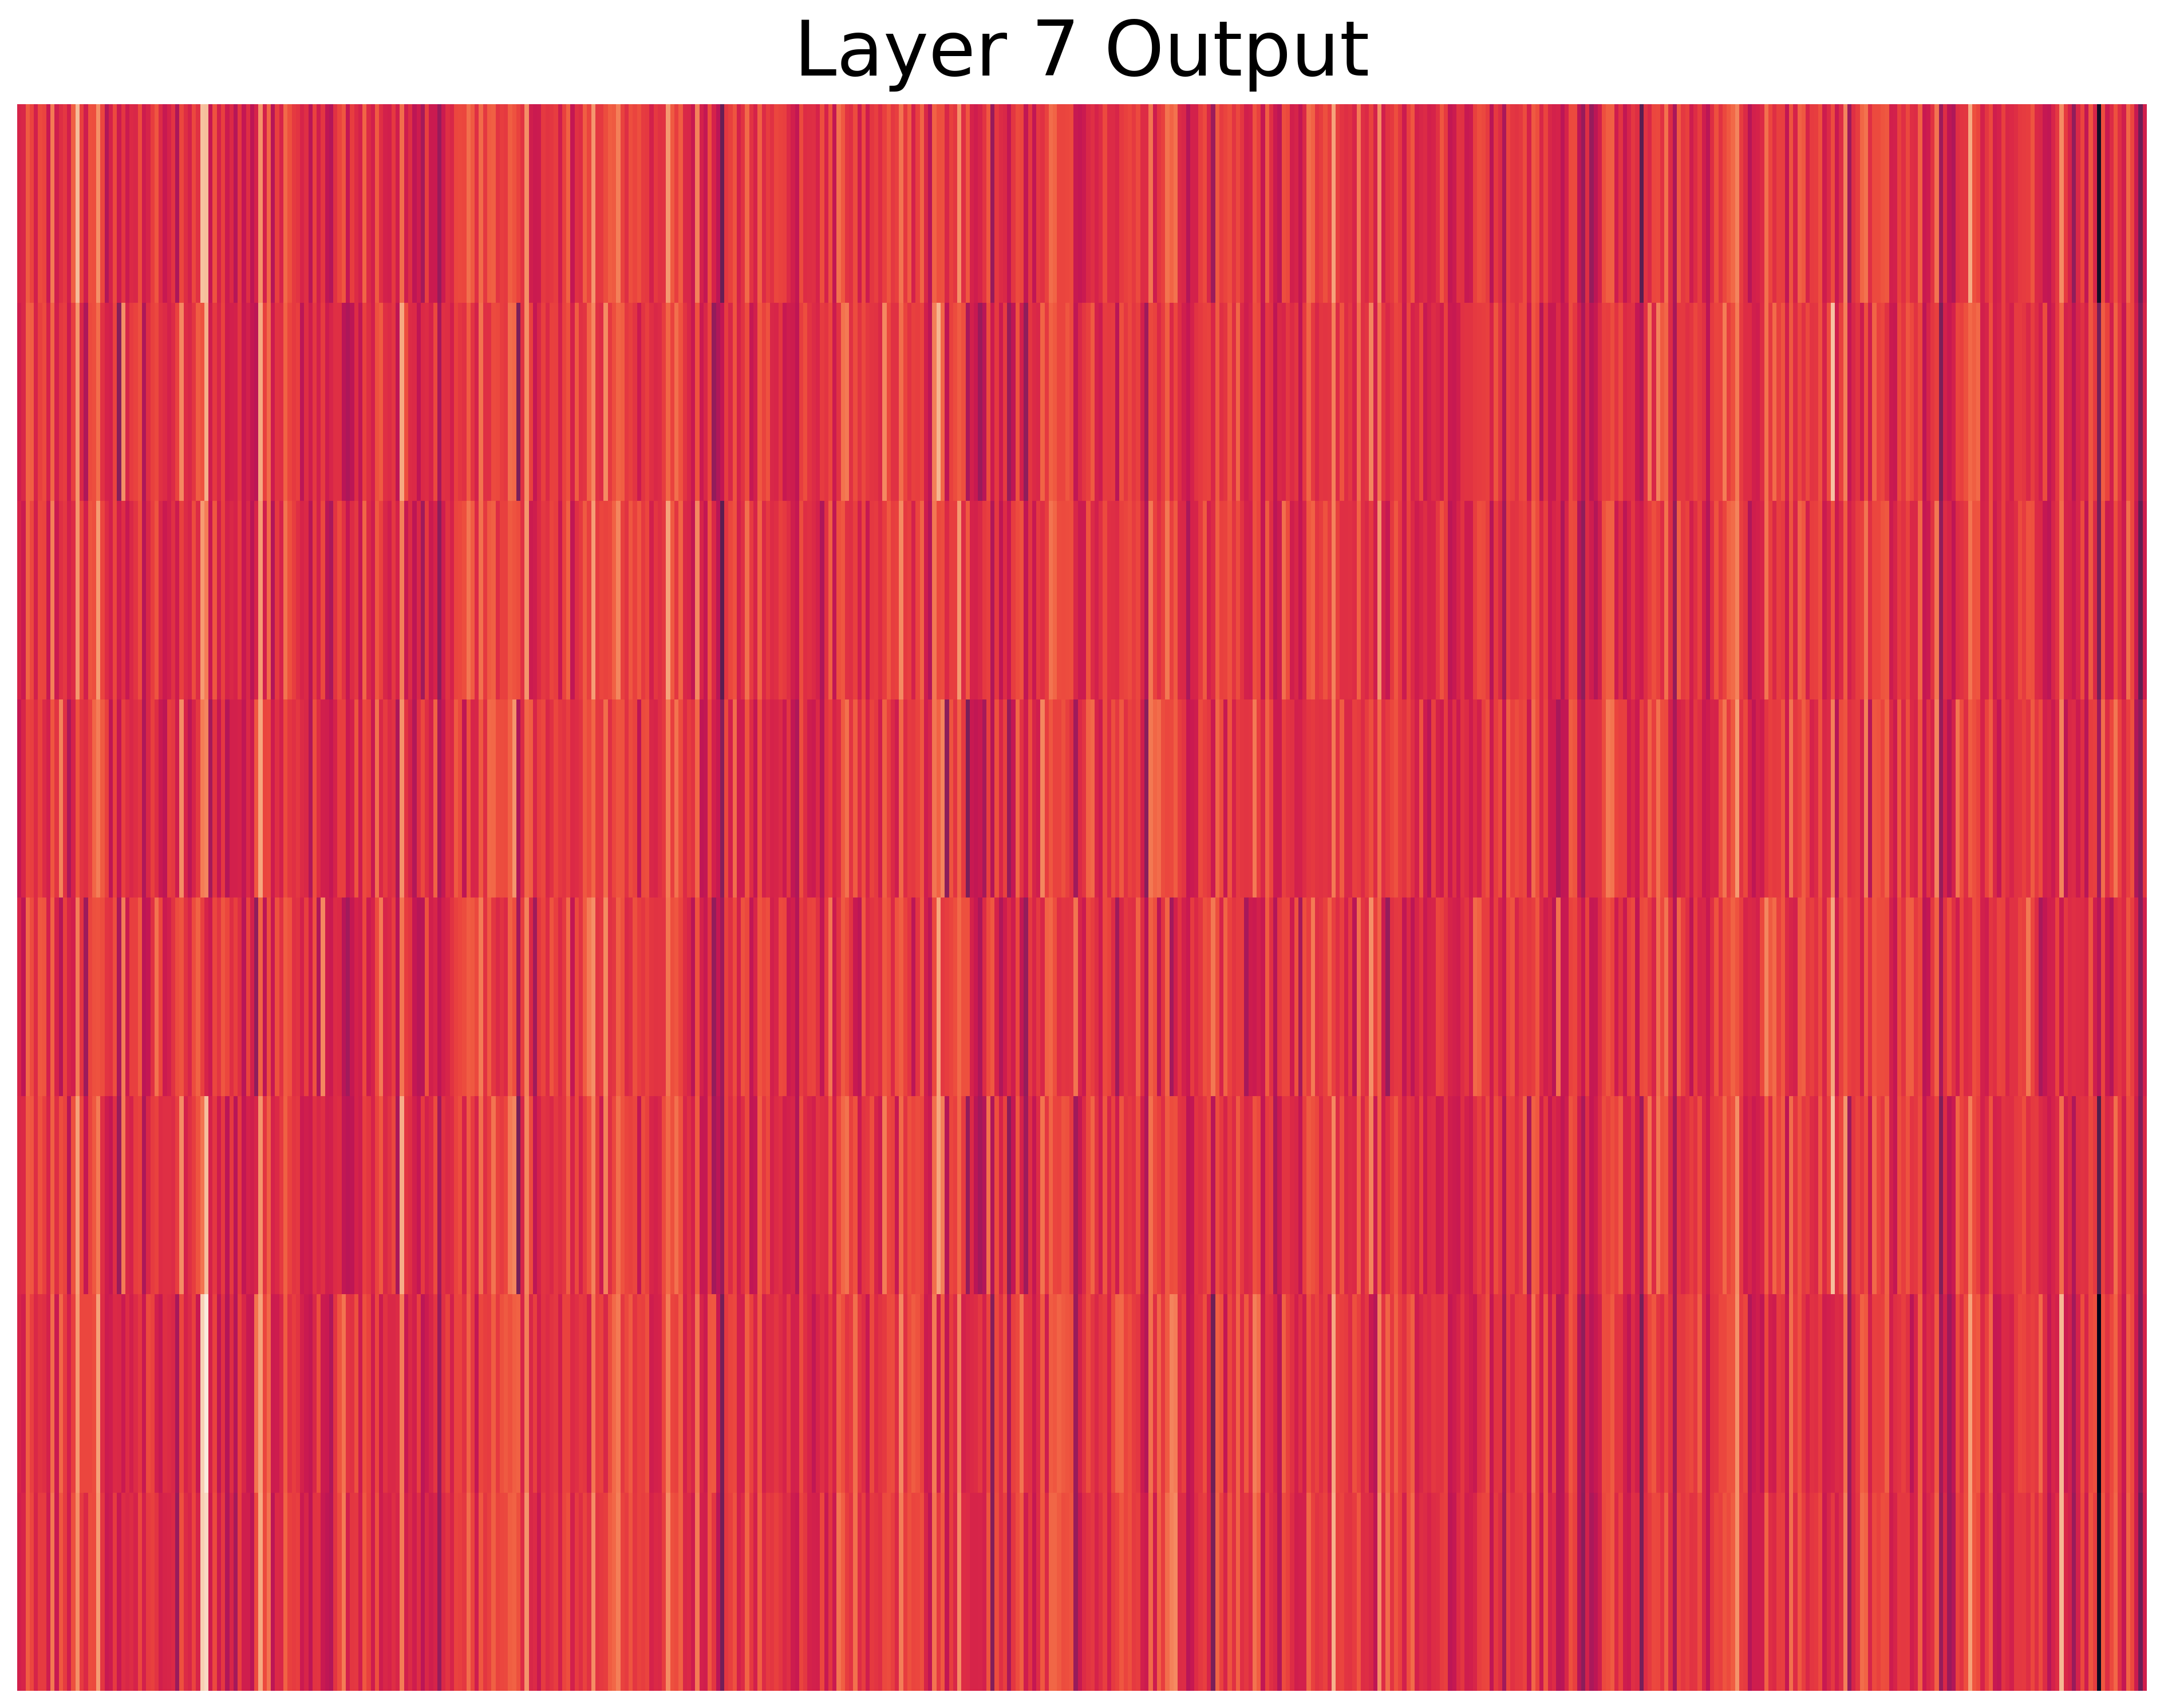

In [70]:
alle = torch.concat([exp.model.init_embedding[0], exp.model.prevs[0][0], exp.model.prevs[1][0]], dim=1)
# sns.heatmap(exp.model.prevs[1][0, [v, v+1], :].detach().cpu().numpy())
with plt.style.context(['science', 'notebook']):
    # for i in range(7):
    #     # sns.heatmap( exp.model.prevs[0][0].detach().cpu().numpy(), cbar=False, xticklabels=False, yticklabels=False)
    #     sns.heatmap( exp.model.prevs[i][0].detach().cpu().numpy(), yticklabels=False, xticklabels=False, cbar=False)
    #     plt.title(f"Layer {i+1} Output")
    #     plt.savefig(f"Layer {i+1} Output.svg")
    sns.heatmap( exp.model.prevs[6][0].detach().cpu().numpy(), yticklabels=False, xticklabels=False, cbar=False)
    plt.title(f"Layer 7 Output")
    # plt.savefig(f"Output.svg")
    


### CKA

In [71]:
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
import torch
import time
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel
from scipy.linalg import svd

from sklearn.metrics.pairwise import linear_kernel

# X 和 Y 的维度可以不一样
sys.path.insert(0,os.path.abspath('/notebooks/4901_revisit_cdtran'))
sys.path.insert(0,os.path.abspath('/notebooks/pytorchtimseries'))
from tqdm.notebook import tqdm


def xy_plot(x, y, pred_y, title=None, y_label=None):
    with plt.style.context(['science', 'notebook']):

        fig, ax = plt.subplots()
        
        x_ticks = np.arange(len(x))
        y_ticks = np.arange(len(x), len(x)+len(y))
        
        # 设置边框粗度
        for spine in ax.spines.values():
            spine.set_linewidth(2)  # 设置边框粗度为2

        
        ax.plot(x_ticks, x, label='lookback', linewidth=3)
        ax.plot(y_ticks, y, label='ground_truth', linewidth=3)
        ax.plot(y_ticks, pred_y, label='prediction', linewidth=3)
    if y_label: plt.ylabel(y_label)
    if title: plt.title(title)
    plt.legend()
    
# X 和 Y 的维度可以不一样
# K = linear_kernel(X, X)  # K: n x n
# L = linear_kernel(Y, Y)  # L: n x n

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def compute_cka(X, Y):
    K = linear_kernel(X, X)
    L = linear_kernel(Y, Y)
    
    K_c = center_kernel(K)
    L_c = center_kernel(L)
    
    hsic = np.trace(K_c @ L_c)
    norm_k = np.trace(K_c @ K_c)
    norm_l = np.trace(L_c @ L_c)
    
    return hsic / np.sqrt(norm_k * norm_l)

def standardize(X):
    mean_vals = X.mean(axis=1, keepdims=True)
    std_vals = X.std(axis=1, keepdims=True)
    return (X - mean_vals) / (std_vals + 1e-8)  # 避免除以零


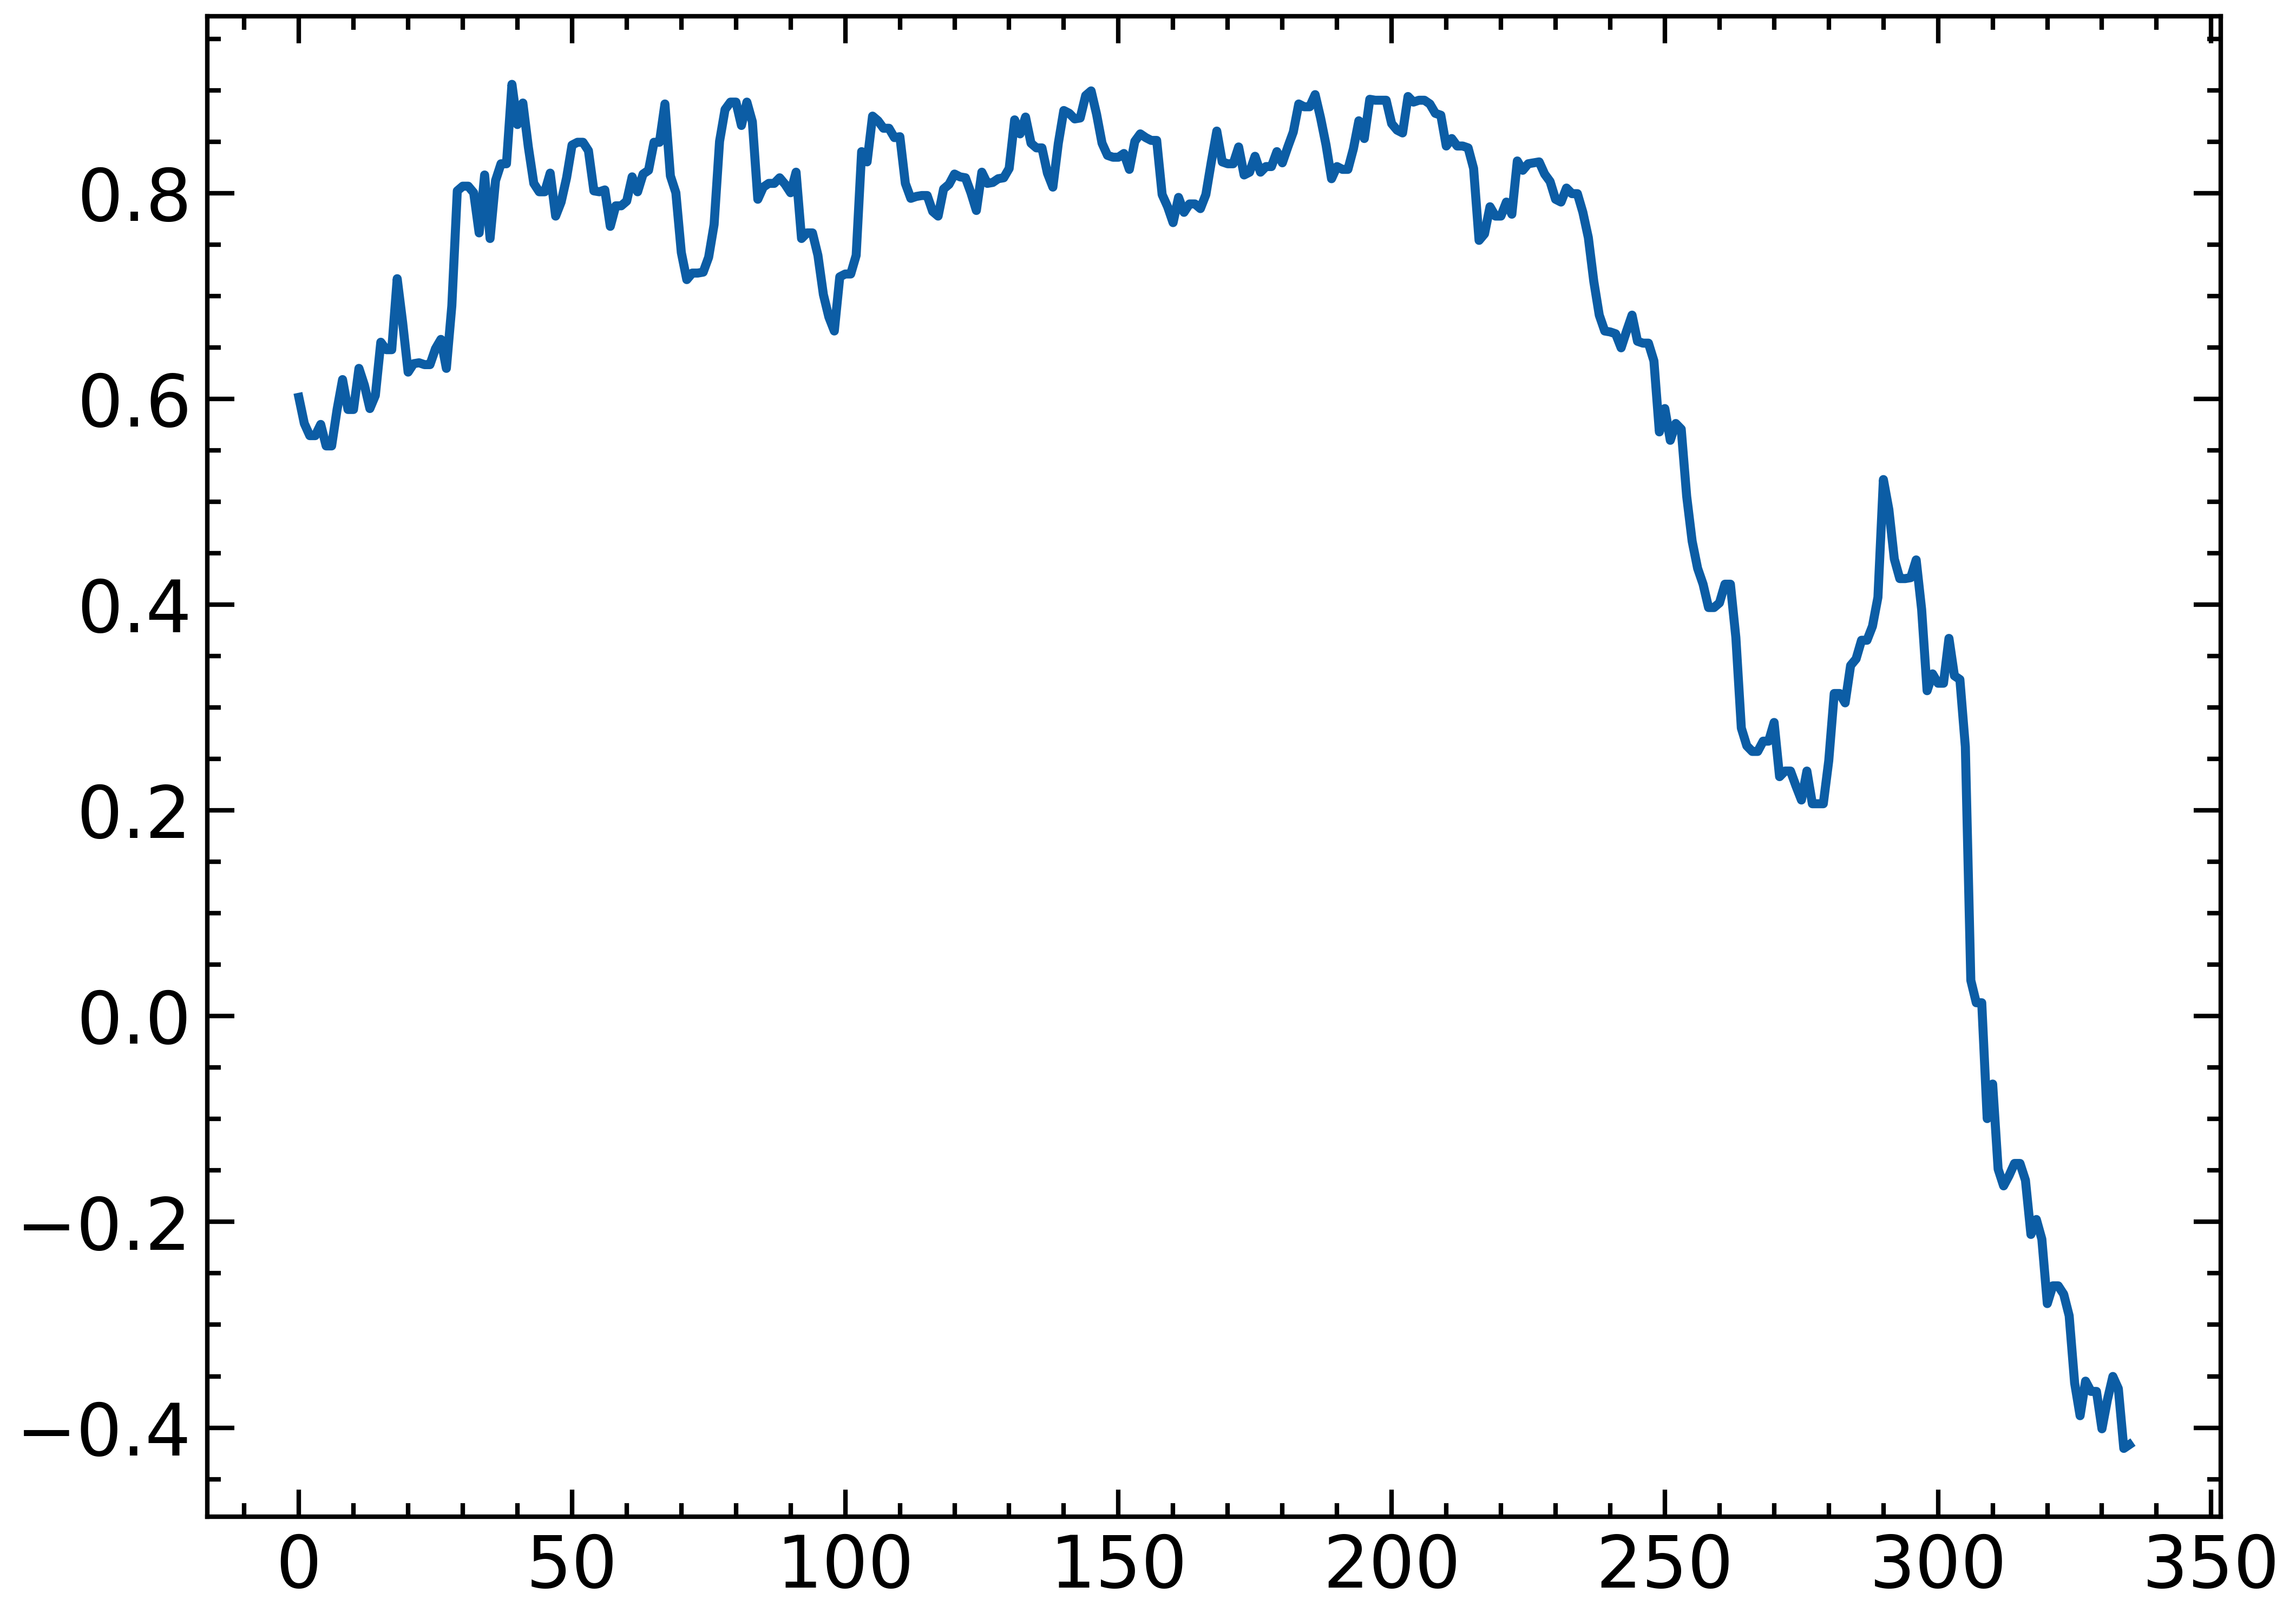

1.0 0.5070225884442033
0.8882155756629961 0.44675735936343003
0.8641027292999707 0.4202179492269441
0.8279977474782688 0.40481838268381093
0.8099399862168584 0.37674140633167524
0.7677733156777076 0.36663830022487043
0.6850248681551805 0.5522921822068216


In [72]:
from src.experiments.CiDPG import CiDPGForecast
plt.plot(x_ticks, plot_x, label='lookback')
# plt.plot(y_ticks, plot_y, label='ground_truth')
# plt.plot(y_ticks, plot_pred_y, label='prediction')
plt.show()
for i in range(0, 7):
    # print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()))
    print(compute_cka(exp.model.prevs[0][0].detach().cpu().numpy(), exp.model.prevs[i][0].detach().cpu().numpy()), 
          compute_cka(standardize(batch_y[0].transpose(0,1).detach().cpu().numpy()) , exp.model.prevs[i][0].detach().cpu().numpy()))
    
    # exp.model.init_embedding[0]
    
def parse_str(s):
    input_str = s.strip()
    lines = input_str.split('\n')



In [73]:
def parse_str(s):
    input_str = s.strip()
    lines = input_str.split('\n')

    array1 = []
    array2 = []
    for line in lines:
        parts = line.split()
        array1.append(float(parts[0]))
        array2.append(float(parts[1]))
    return array1, array2
a = """
1.0 0.5070225884442033
0.8882155756629961 0.44675735936343003
0.8641027292999707 0.4202179492269441
0.8279977474782688 0.40481838268381093
0.8099399862168584 0.37674140633167524
0.7677733156777076 0.36663830022487043
0.6850248681551805 0.5522921822068216
"""

a1, a2 = parse_str(a)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


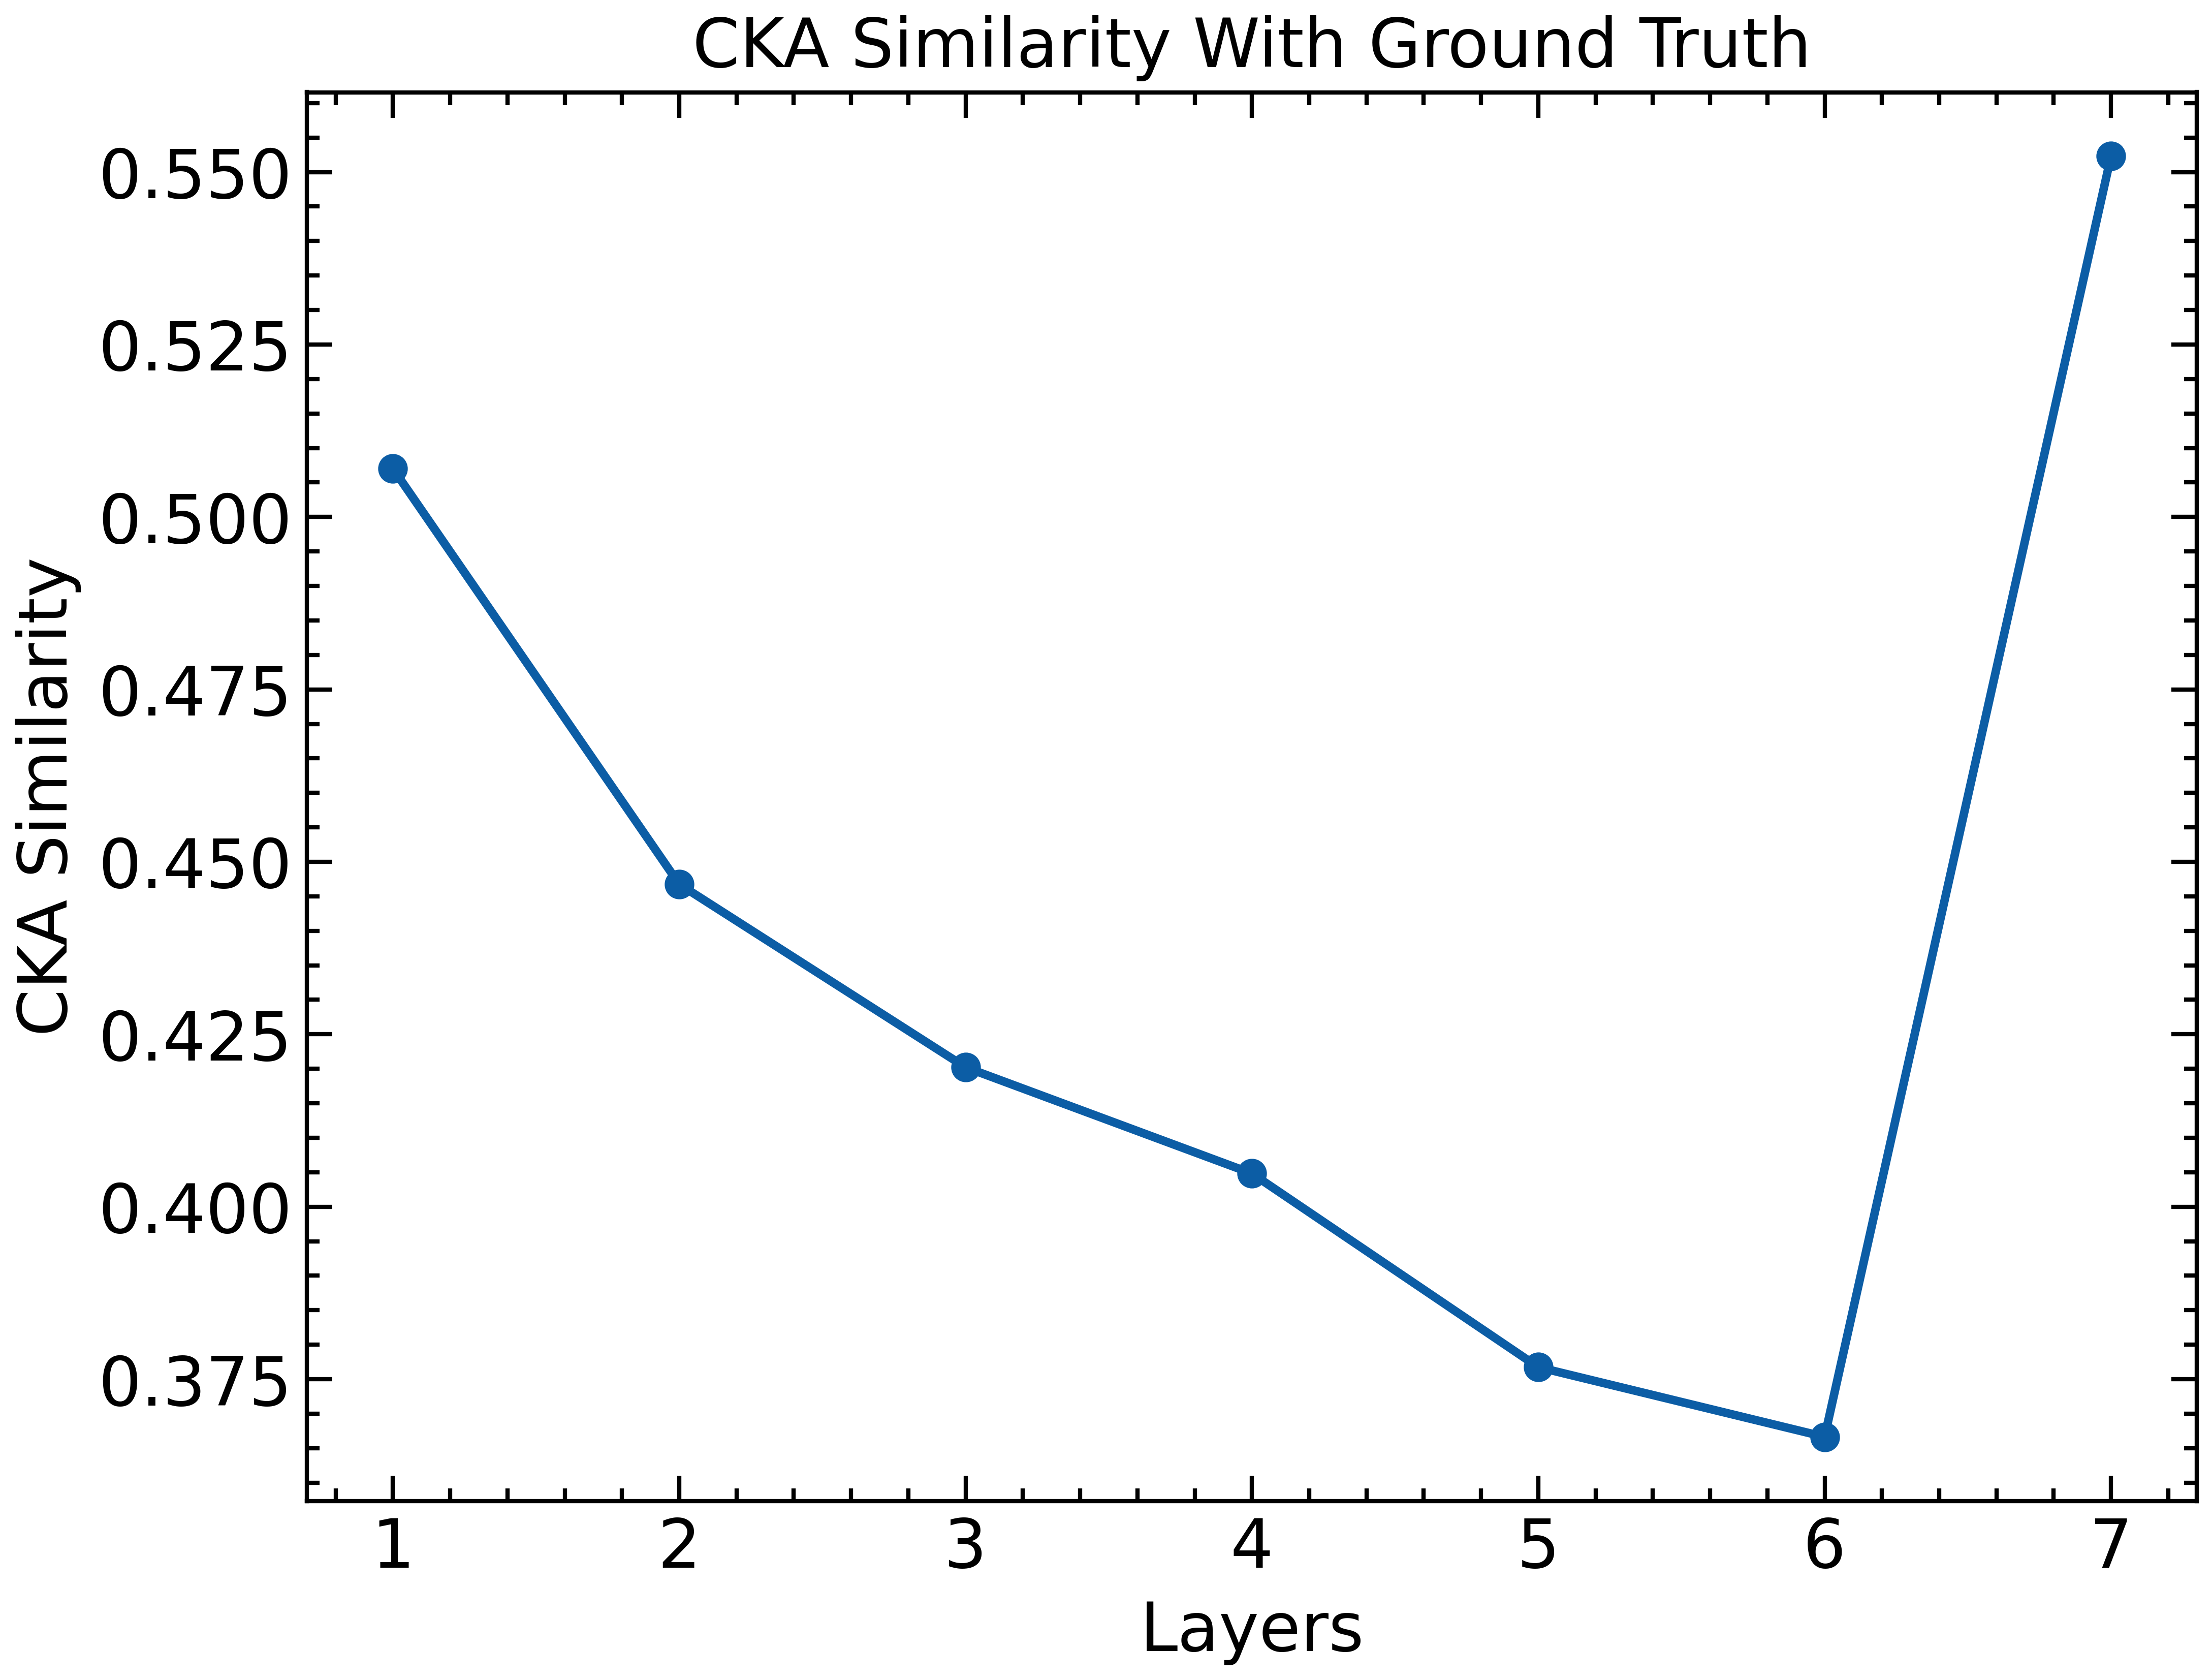

In [76]:
# plt.plot([etth1_1st, etth2_1st, ettm1_1st, ettm2_1st])

plt.figure()
x = list(range(1, 8))  # Line numbers for x-axis
plt.plot(x, a2, marker='o')

plt.title('CKA Similarity With Ground Truth')
plt.ylabel('CKA Similarity')
plt.xlabel('Layers')
plt.legend()



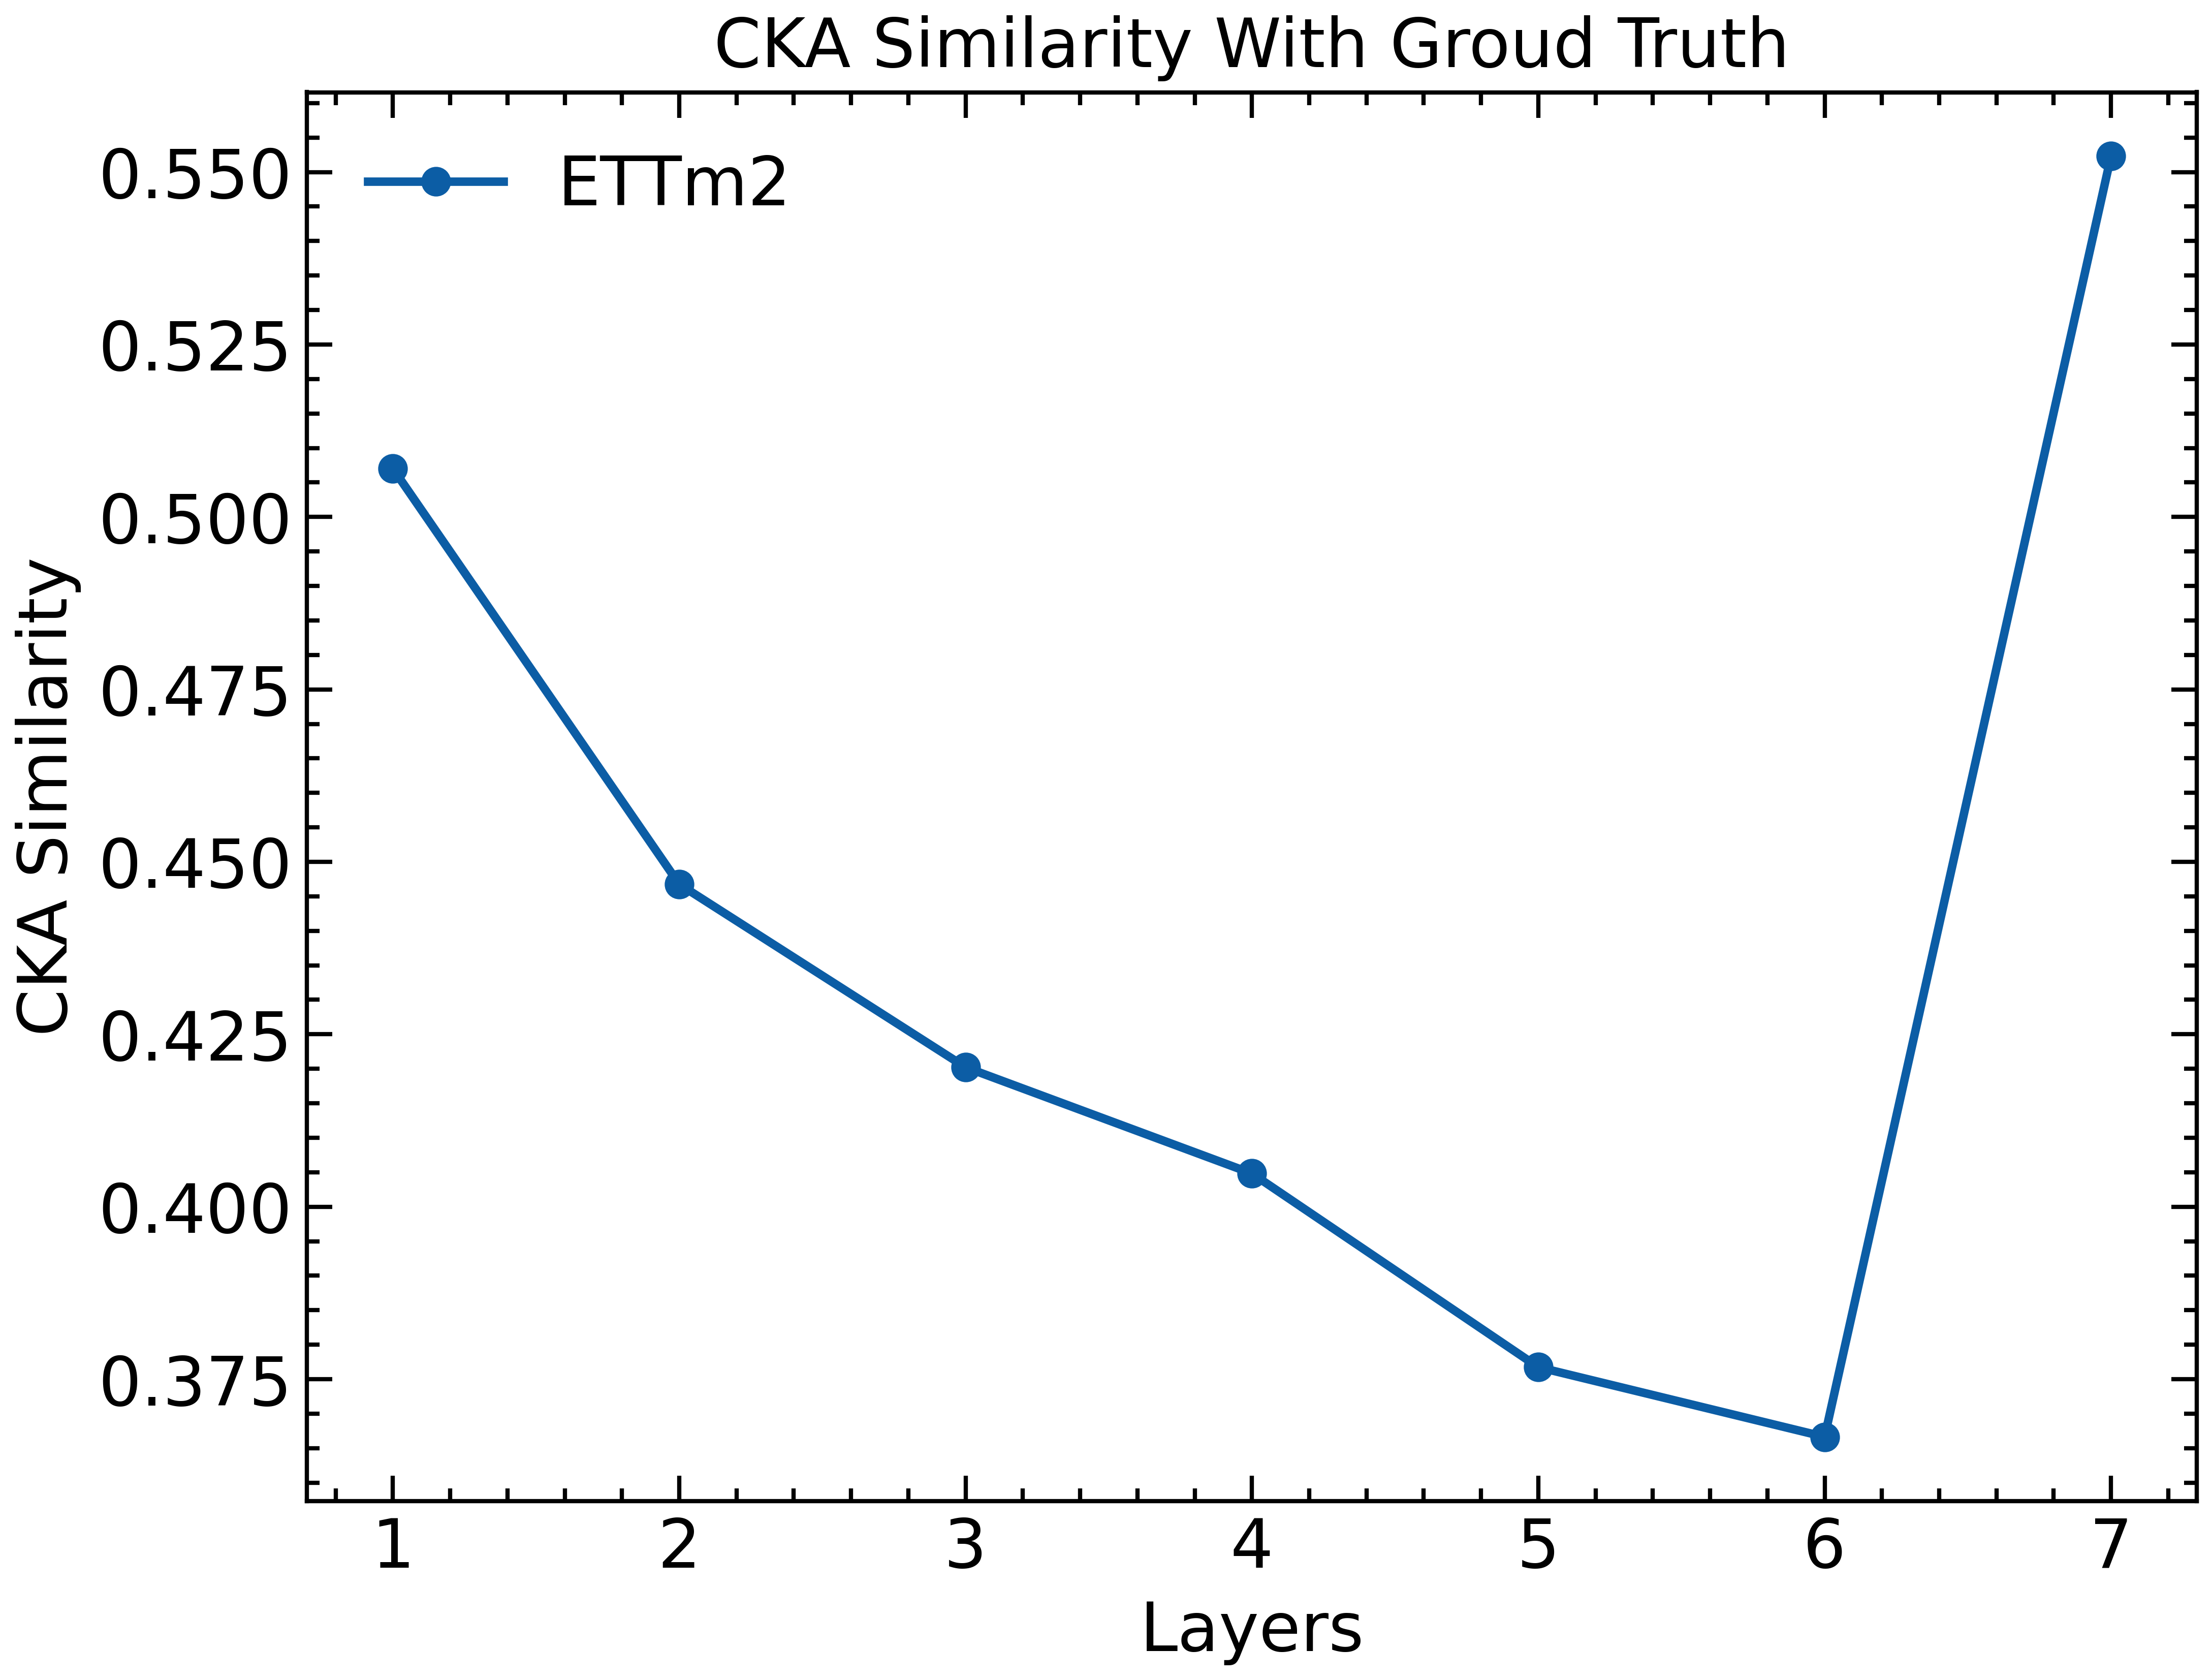

In [75]:
plt.plot(x, a2, label="ETTm2", marker='o')

plt.title('CKA Similarity With Groud Truth')
plt.ylabel('CKA Similarity')
plt.xlabel('Layers')
plt.legend()
